# Finding Politeness
### https://arxiv.org/pdf/1306.6078.pdf
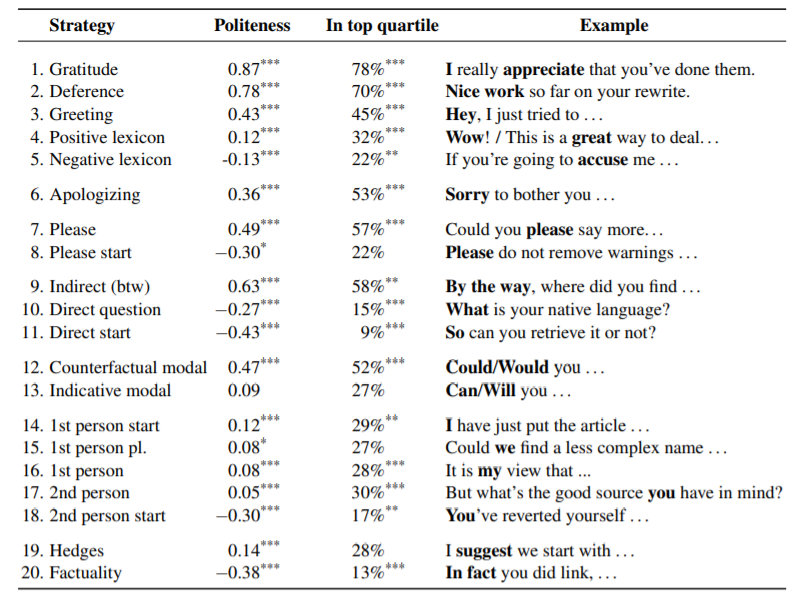

In [ ]:
# {'feature_politeness_==Please==': 15,
#  'feature_politeness_==Please_start==': 11,
#  'feature_politeness_==HASHEDGE==': 1176,
#  'feature_politeness_==Indirect_(btw)==': 0,
#  'feature_politeness_==Hedges==': 424,
#  'feature_politeness_==Factuality==': 104,
#  'feature_politeness_==Deference==': 1,
#  'feature_politeness_==Gratitude==': 23,
#  'feature_politeness_==Apologizing==': 0,
#  'feature_politeness_==1st_person_pl.==': 119,
#  'feature_politeness_==1st_person==': 453,
#  'feature_politeness_==1st_person_start==': 295,
#  'feature_politeness_==2nd_person==': 175,
#  'feature_politeness_==2nd_person_start==': 14,
#  'feature_politeness_==Indirect_(greeting)==': 0,
#  'feature_politeness_==Direct_question==': 154,
#  'feature_politeness_==Direct_start==': 117,
#  'feature_politeness_==HASPOSITIVE==': 2431,
#  'feature_politeness_==HASNEGATIVE==': 1558,
#  'feature_politeness_==SUBJUNCTIVE==': 14,
#  'feature_politeness_==INDICATIVE==': 20}

In [1]:
import collections
import glob
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None, 'display.max_rows', None, )

dataset_dir = "./datasets/"

#SUBSETS = "train dev test".split()
SUBSETS = ["train"]


datasets = collections.defaultdict(list)

for subset in SUBSETS:
    for filename in glob.glob(dataset_dir + subset + "/*"):
        with open(filename, 'r') as f:
            datasets[subset].append(json.load(f))
            
all_pairs = sum(datasets.values(), [])

def total_and_average_len(list_of_lists):
    big_list = sum(list_of_lists, [])
    return len(big_list), len(big_list)/len(list_of_lists)

def count_dataset(pairs, subset):
    # TODO: Add double-annotated and adjudicated
    review_total, review_average = total_and_average_len([pair["review_sentences"] for pair in pairs])
    rebuttal_total, rebuttal_average = total_and_average_len([pair["rebuttal_sentences"] for pair in pairs])
    return {
        "subset":subset,
        "pairs": len(pairs),
        "forums": len(set(pair["metadata"]["forum_id"] for pair in pairs)),
        "adjudicated": len([pair for pair in pairs if pair["metadata"]["annotator"] == "anno0"]),
        "review_sentences": review_total,
        "rebuttal_sentences": rebuttal_total,
        "review_avg_sentences": review_average,
        "rebuttal_avg_sentences": rebuttal_average,
        
    }
# Distribution of examples over sets
df_dicts = [count_dataset(pairs, subset) for subset, pairs in datasets.items()]
df = pd.DataFrame.from_dict(df_dicts)

In [2]:
len(all_pairs)

# all_pairs[0]

251

In [48]:
from tools.convokit_politeness import get_convokit_politeness_labels

# pair = all_pairs[1]

sent = {
    'metadata': {'review_id': 'xyz'},
    'review_sentences': [],
    'rebuttal_sentences': []
}
pol_lab = {}
for idx, pair in enumerate(all_pairs):
    for i, s in enumerate(pair['review_sentences']):
        single_sent = {
        'metadata': {'review_id': 'xyz'},
        'review_sentences': [s],
        'rebuttal_sentences': []
        }

        pol_dict = get_convokit_politeness_labels(single_sent)
        
        #formatting
        relevant_keys = ','.join(list(map(lambda key: key[21:-2], filter(lambda key: pol_dict[key] != 0, pol_dict.keys()))))
        
        all_pairs[idx]['review_sentences'][i]['politeness'] = relevant_keys

In [222]:
df = pd.DataFrame({'review_id':[],'rating':[], 'sentence_index':[], 'text':[], 'coarse':[], 'fine':[], 'asp':[], 'pol':[],
       'politeness':[]}, columns = ['review_id', 'sentence_index', 'text', 'coarse', 'fine', 'asp', 'pol',
       'politeness'])
for pair in all_pairs:
    rs = pd.json_normalize(pair, record_path=['review_sentences'])
    rs.loc[rs['politeness']=='','politeness'] = np.nan
    rs['rating'] = pair['metadata']['rating']
    df = df.append(rs)

df.head()

,review_id,sentence_index,text,coarse,fine,asp,pol,politeness,rating
0,B1euHOqi37,0.0,The present paper proposes a fast approximation to the softmax computation when the number of classes is very large.,arg_structuring,arg-structuring_summary,none,none,HASPOSITIVE,6.0
1,B1euHOqi37,1.0,This is typically a bottleneck in deep learning architectures.,arg_structuring,arg-structuring_summary,none,none,HASHEDGE,6.0
2,B1euHOqi37,2.0,The approximation is a sparse two-layer mixture of experts.,arg_structuring,arg-structuring_summary,none,none,NaN,6.0
3,B1euHOqi37,3.0,"The paper lacks rigor and the writing is of low quality, both in its clarity and its grammar.",arg_evaluative,none,asp_clarity,pol_negative,"HASPOSITIVE,HASNEGATIVE",6.0
4,B1euHOqi37,4.0,See a list of typos below.,arg_structuring,arg-structuring_heading,none,none,NaN,6.0


In [131]:
df.groupby(['review_id'])[['review_id']].count().shape

(251, 1)

In [223]:
pol_df = pd.DataFrame({'Please': [],
 'Please_start': [],
 'HASHEDGE': [],
 'Indirect_(btw)': [],
 'Hedges': [],
 'Factuality': [],
 'Deference': [],
 'Gratitude': [],
 'Apologizing': [],
 '1st_person_pl.': [],
 '1st_person': [],
 '1st_person_start': [],
 '2nd_person': [],
 '2nd_person_start': [],
 'Indirect_(greeting)': [],
 'Direct_question': [],
 'Direct_start': [],
 'HASPOSITIVE': [],
 'HASNEGATIVE': [],
 'SUBJUNCTIVE': [],
 'INDICATIVE': []}, columns=['Please', 'Please_start', 'HASHEDGE', 'Indirect_(btw)', 'Hedges', 'Factuality', 'Deference', 'Gratitude', 'Apologizing', '1st_person_pl.', '1st_person', '1st_person_start', '2nd_person', '2nd_person_start', 'Indirect_(greeting)', 'Direct_question', 'Direct_start', 'HASPOSITIVE', 'HASNEGATIVE', 'SUBJUNCTIVE', 'INDICATIVE'])
   
for col in ['coarse', 'asp', 'fine', 'pol', 'politeness', 'text', 'rating']:
    pol_df[col] = df[col]
pol_df = pol_df.fillna(0)
pol_df = pol_df.reset_index()

for i, row in pol_df.iterrows():
    if (row['politeness'] == 0): continue
    else:
        for label in row['politeness'].split(','):
            pol_df.loc[i, label] = 1
        
# pol_df.drop('politeness', axis=1, inplace=True)
pol_df.head()

,index,Please,Please_start,HASHEDGE,Indirect_(btw),Hedges,Factuality,Deference,Gratitude,Apologizing,...,HASNEGATIVE,SUBJUNCTIVE,INDICATIVE,coarse,asp,fine,pol,politeness,text,rating
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,arg_structuring,none,arg-structuring_summary,none,HASPOSITIVE,The present paper proposes a fast approximation to the softmax computation when the number of classes is very large.,6.0
1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,arg_structuring,none,arg-structuring_summary,none,HASHEDGE,This is typically a bottleneck in deep learning architectures.,6.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,arg_structuring,none,arg-structuring_summary,none,0,The approximation is a sparse two-layer mixture of experts.,6.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,arg_evaluative,asp_clarity,none,pol_negative,"HASPOSITIVE,HASNEGATIVE","The paper lacks rigor and the writing is of low quality, both in its clarity and its grammar.",6.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,arg_structuring,none,arg-structuring_heading,none,0,See a list of typos below.,6.0


## Coarse vs politeness

In [215]:
pol_df['politeness'].value_counts()[0:5]

0                          1171
HASPOSITIVE                 926
HASNEGATIVE                 436
HASPOSITIVE,HASNEGATIVE     377
HASHEDGE,HASPOSITIVE        187
Name: politeness, dtype: int64

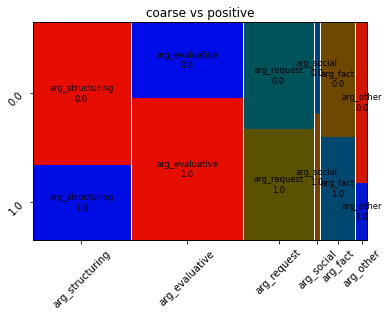

In [178]:
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic

mosaic(pol_df, ['coarse', 'HASPOSITIVE'], title='coarse vs positive', label_rotation=45, statistic=True)
plt.show()

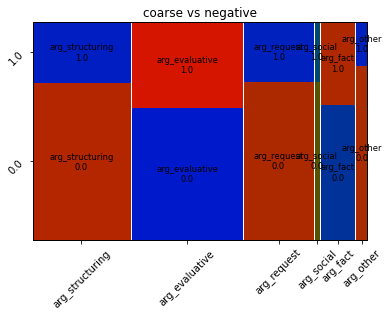

In [181]:
mosaic(pol_df, ['coarse', 'HASNEGATIVE'], title='coarse vs negative', label_rotation=45, statistic=True)
plt.show()

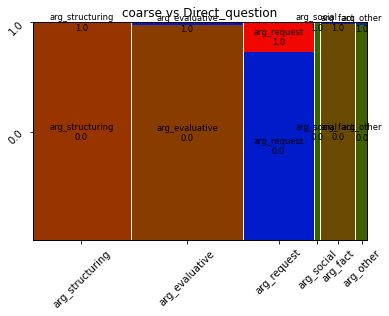

In [182]:
mosaic(pol_df, ['coarse', 'Direct_question'], title='coarse vs Direct_question', label_rotation=45, statistic=True)
plt.show()

<AxesSubplot:>

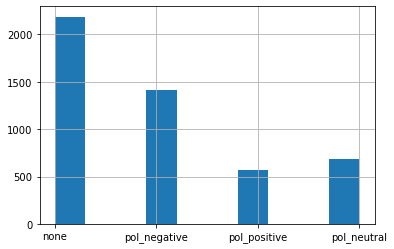

In [210]:
pol_df.pol.hist()

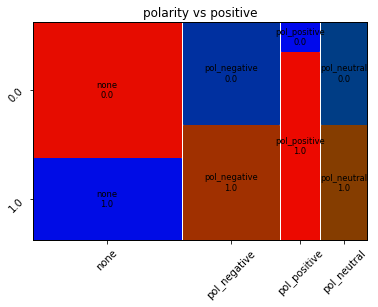

In [212]:
mosaic(pol_df, ['pol', 'HASPOSITIVE'], title='polarity vs positive', label_rotation=45, statistic=True)
plt.show()

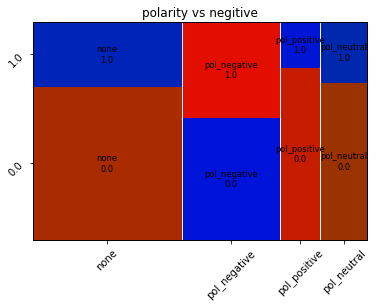

In [213]:
mosaic(pol_df, ['pol', 'HASNEGATIVE'], title='polarity vs negitive', label_rotation=45, statistic=True)
plt.show()



## Which are the sentences with polarity positive and politeness = HASNEGATIVE

In [224]:
pol_df.loc[pol_df.HASNEGATIVE == 1,['pol','text']].loc[pol_df.pol == 'pol_positive', ['text']][0:5]

,text
26,The premise of the paper is very interesting and the overall problem is definitely of high interest and high potential impact.
34,"In summary, I feel the paper tackles an interesting problem with an interesting approach, but the content could be organized much better."
48,"The paper addresses active deep learning which is certainly an interesting research direction since in practice, labeled data is notoriously scarce."
93,1. The authors find a new angle for learning with noisy labels.
166,"This paper is reasonably interesting---it joins an effort to produce non-Euclidean models in a tractable way, which is fairly challenging, but could have a good impact."


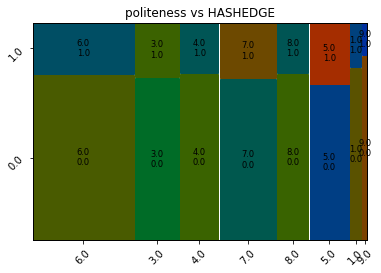

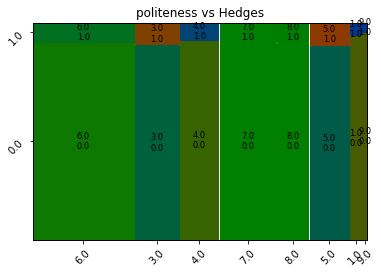

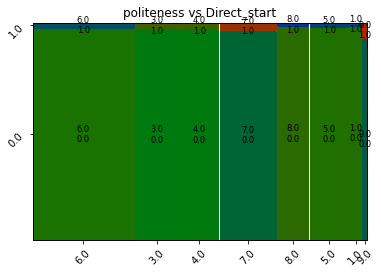

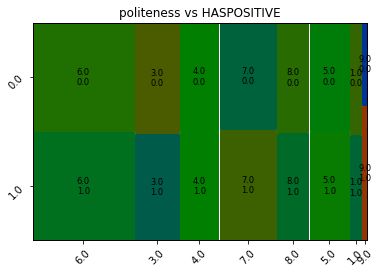

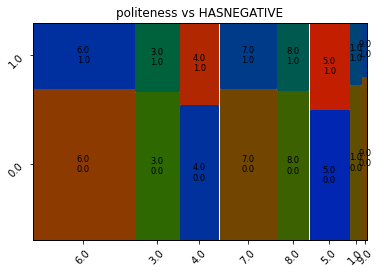

In [235]:
ulabels = ['HASHEDGE', 'Hedges', 'Direct_start', 'HASPOSITIVE', 'HASNEGATIVE']

for l in ulabels:   
    mosaic(pol_df, ['rating', l], title=f'politeness vs {l}', label_rotation=45, statistic=True)
    plt.show()

# sentence characteristic vs politeness

In [265]:
pivot = pol_df.loc[:,['HASHEDGE', 'Hedges', 'Direct_start', 'HASPOSITIVE', 'HASNEGATIVE', 'coarse', 'asp', 'fine', 'pol', 'politeness', 'text', 'rating']]
pivot_pola = pol_df.loc[:,['coarse', 'asp', 'fine', 'pol', 'text', 'rating']]

In [285]:
pivot_pola.loc[pivot.rating==4].groupby(['coarse', 'pol']).agg({'pol':'count'})

pol
coarse          pol              
arg_evaluative  pol_negative  190
                pol_neutral    10
                pol_positive   41
arg_fact        none           75
arg_other       none           23
arg_request     pol_negative   41
                pol_neutral    57
arg_social      none            5
arg_structuring none          130

C:\Users\disha\AppData\Local\Temp/ipykernel_15668/3762685425.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  coarse_politness = pivot.loc[pivot.rating==rating].groupby('coarse')['HASHEDGE', 'Hedges', 'Direct_start', 'HASPOSITIVE', 'HASNEGATIVE'].sum()


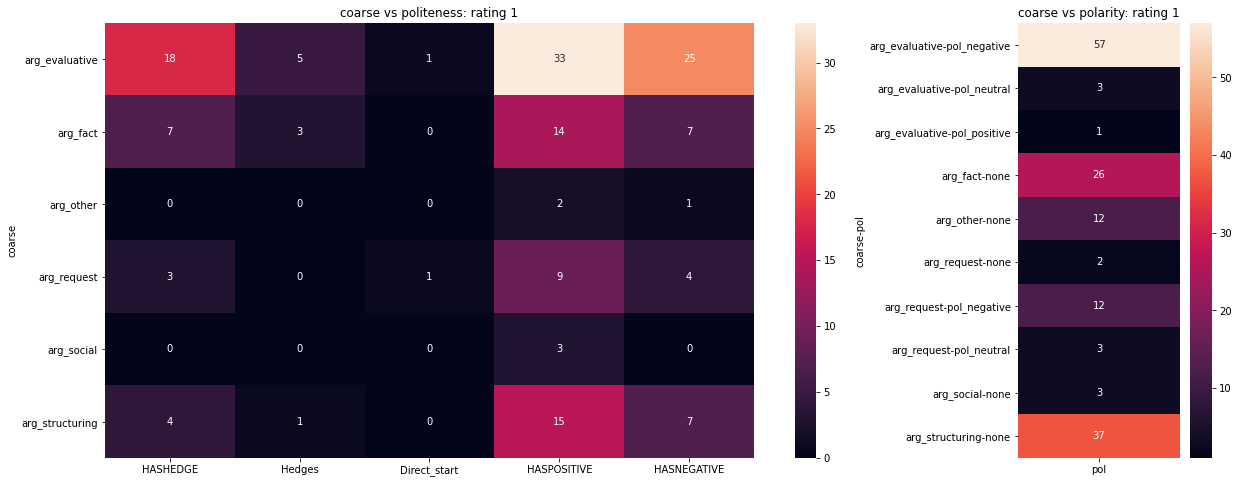

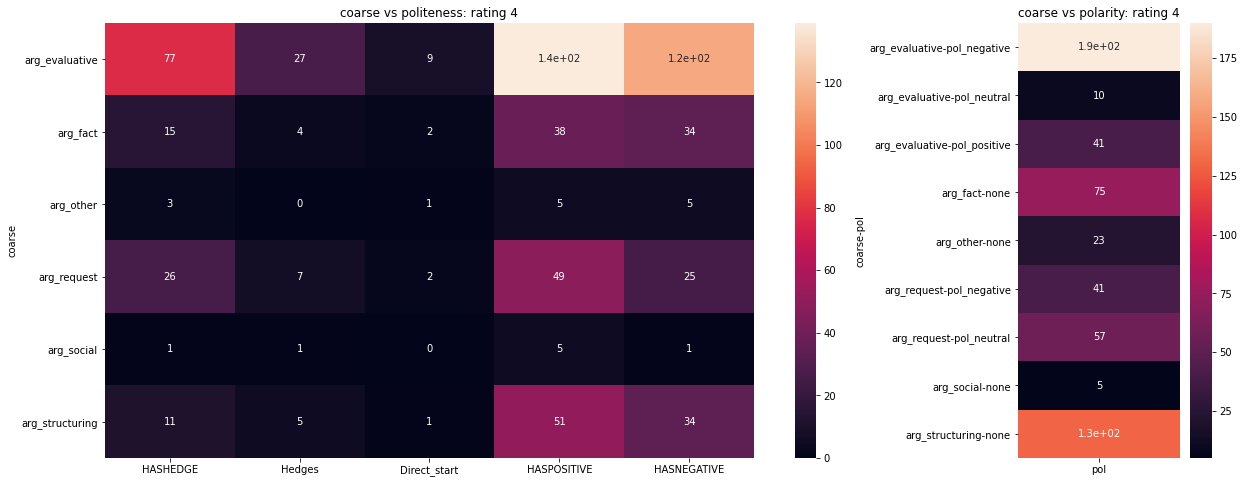

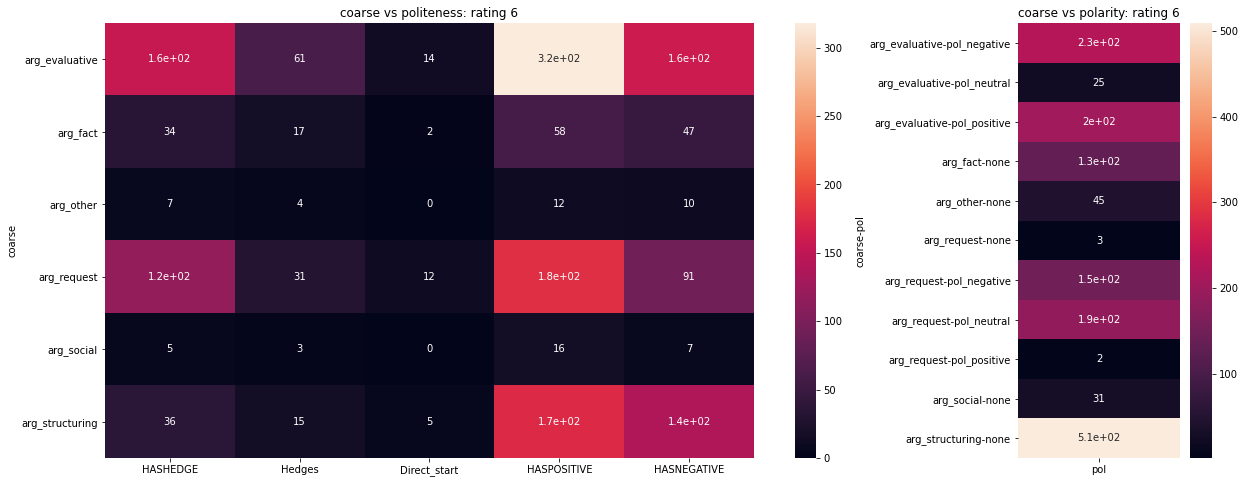

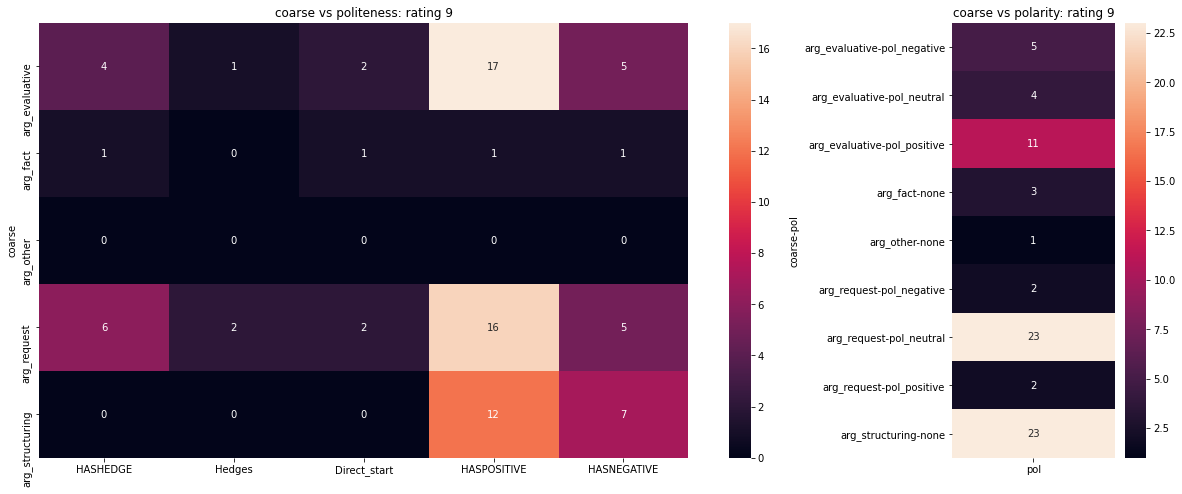

In [286]:
import seaborn as sns

for rating in [1,4,6,9]:
    coarse_politness = pivot.loc[pivot.rating==rating].groupby('coarse')['HASHEDGE', 'Hedges', 'Direct_start', 'HASPOSITIVE', 'HASNEGATIVE'].sum()
    coarse_polarity = pivot_pola.loc[pivot.rating==rating].groupby(['coarse', 'pol']).agg({'pol':'count'})

    fig, (s0, s1) = plt.subplots(1, 2, figsize=(20,8), gridspec_kw={'width_ratios': [4, 1]})
    sns.heatmap(coarse_politness, annot = True, ax=s0)
    plt.title(f'coarse vs politeness: rating {rating}')

    sns.heatmap(coarse_polarity, annot=True, ax=s1)
    s0.set_title(f'coarse vs politeness: rating {rating}')
    s1.set_title(f'coarse vs polarity: rating {rating}')

### If rating is 1/4, then equal proportion of arg evaluative has politness +/- but polarity is different (high negatives)
### Arg request is similar for politeness and polarity rating 1